In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

torch.random.manual_seed(42)
np.random.seed(42)

In [3]:
#Dataset Preparation

class EuropenaDataset(Dataset):
    def __init__(self, image_path, file_path, file_list):
        self.image_path= image_path
        self.file_path= file_path
        self.images_dict= self.image_process()
        self.labels_dict= self.text_process()
        self.file_list= file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        filename= self.file_list[index]
        return self.images_dict[filename], self.labels_dict[filename]

    def image_process(self):
        transform= transforms.Compose(
            [
                transforms.Resize((50, 200)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ]
        )
        images= {val:transform(Image.open(os.path.join(self.image_path, val)).convert("RGB"))
                 for val in os.listdir(self.image_path)}
        return images

    def text_process(self):
        with open(self.file_path) as f:
            text= f.read().split("\n")

        labels_dict={}
        for i in range(len(text)):
            ind= text[i].find("=")
            filename= text[i][:ind].strip()
            cont= text[i][ind+1:].strip()

            cont_cleaned = re.sub(r'[^a-zA-Z0-9 ]+', '', cont)
            labels_dict[filename]= cont_cleaned
        return labels_dict

with open("./data_words.txt") as f:
    text= f.read().split("\n")

file_list=[]
for i in range(len(text)):
    try:
        ind= text[i].index("=")
        filename= text[i][:ind].strip()
        file_list.append(filename)
    except:
        continue
train_size= int(len(file_list)*0.8)
train_file_inds= np.random.choice(len(file_list), size=(train_size, ), replace=False)
train_file_names= [file_list[i] for i in train_file_inds]
test_file_names= [val for val in file_list if val not in train_file_names]

train_set= EuropenaDataset("./cropped_words", "./data_words.txt", train_file_names)
test_set= EuropenaDataset("./cropped_words", "./data_words.txt", test_file_names)
train_loader= DataLoader(train_set, 16)
test_loader= DataLoader(test_set, 16)

In [4]:
#Utility Functions
criterion = nn.CTCLoss(blank=0)
alphabet= [val for val in "-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"]
encoder_map= {ind:val for val, ind in enumerate(alphabet)}
decoder_map= {val:ind for val, ind in enumerate(alphabet)}

def encode_text(text_batch):
    text_lengths=[]
    for text in text_batch:
        text_lengths.append(len(text))
    strv= "".join(text_batch)
    encoding=[encoder_map[char] for char in strv]
    text_lengths= torch.IntTensor(text_lengths)
    encoding= torch.IntTensor(encoding)
    return encoding, text_lengths

def calculate_CTCLoss(output_logits, text_labels, device):
    log_probs= nn.functional.log_softmax(output_logits, 2)
    input_lengths= torch.full(size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.int32).to(device)
    targets, target_lengths= encode_text(text_labels)
    return criterion(log_probs, targets, input_lengths, target_lengths)

def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [decoder_map[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [5]:
batch_size = 16
num_chars = len(encoder_map)
rnn_hidden_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
resnet = resnet18(pretrained=True)

c:\Users\deban\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deban\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
class CRNN(nn.Module):

    def __init__(self, num_chars, rnn_hidden_size=256):

        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size

        self.seq = nn.Sequential(*list(resnet.children())[:7]).to("cpu")

        self.linear1 = nn.Sequential(nn.Linear(1024, 512),
                                     nn.Dropout(0.2),
                                     nn.ReLU(),
                                     nn.Linear(512, 256))

        self.rnn1 = nn.LSTM(input_size=rnn_hidden_size,
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=2,
                            dropout=0.2)

        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)


    def forward(self, X):
        X= self.seq(X)
        X= X.permute(0,3,1,2)
        b, t, _, _ = X.shape
        X= X.view(b, t, -1)
        X= self.linear1(X)
        X, _ = self.rnn1(X)
        X = self.linear2(X)
        X = X.permute(1, 0, 2)
        return X

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

In [10]:
epoch_losses = []
test_epoch_losses = []

for epoch in range(1, num_epochs+1):
    crnn.train()
    epoch_loss_list = []
    for image_batch, text_batch in train_loader:
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = calculate_CTCLoss(text_batch_logits, text_batch, device)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue

        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()
    epoch_loss = np.mean(epoch_loss_list)
    epoch_losses.append(epoch_loss)
    lr_scheduler.step(epoch_loss)

    crnn.eval()
    test_epoch_loss_list = []
    with torch.inference_mode():
        for image_batch, text_batch in test_loader:
            text_batch_logits = crnn(image_batch.to(device))
            loss = calculate_CTCLoss(text_batch_logits, text_batch, device)
            iteration_loss = loss.item()
            if np.isnan(iteration_loss) or np.isinf(iteration_loss):
                continue
            test_epoch_loss_list.append(iteration_loss)
    test_epoch_loss = np.mean(test_epoch_loss_list)
    test_epoch_losses.append(test_epoch_loss)

    print("Epoch:{}  Train Loss:{}  Test Loss: {}".format(epoch, epoch_loss, test_epoch_loss))

Epoch:1  Train Loss:3.4731808347565134  Test Loss: 3.0107797839926937
Epoch:2  Train Loss:2.458435390098243  Test Loss: 1.8751136368305987
Epoch:3  Train Loss:1.5842683704846214  Test Loss: 1.3607881101402077
Epoch:4  Train Loss:1.2606917689861863  Test Loss: 1.1550536779363183
Epoch:5  Train Loss:1.0982734324259051  Test Loss: 1.0114679811774074
Epoch:6  Train Loss:0.9824755316430872  Test Loss: 0.9863931872957462
Epoch:7  Train Loss:0.9242007535111391  Test Loss: 0.9218032123614462
Epoch:8  Train Loss:0.859545601719019  Test Loss: 0.900417598863366
Epoch:9  Train Loss:0.8191549528158453  Test Loss: 0.8487451852058352
Epoch:10  Train Loss:0.7852462433456804  Test Loss: 0.8374804900419758
Epoch:11  Train Loss:0.7655119483835959  Test Loss: 0.8355328032034934
Epoch:12  Train Loss:0.7431564062334705  Test Loss: 0.8175519360481082
Epoch:13  Train Loss:0.7242213743297677  Test Loss: 0.814755421721567
Epoch:14  Train Loss:0.7066529675819087  Test Loss: 0.816472921218421
Epoch:15  Train Loss

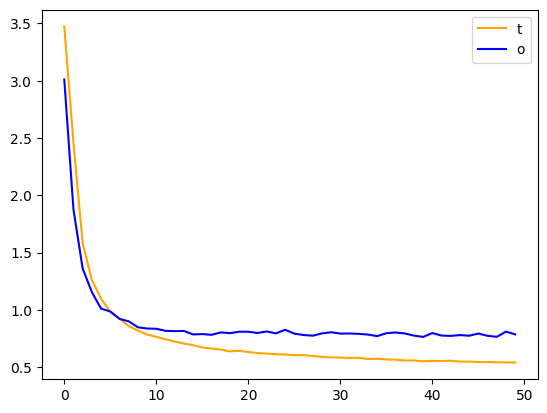

In [11]:
plt.plot(range(len(epoch_losses)), epoch_losses, c="orange", label="train loss")
plt.plot(range(len(test_epoch_losses)), test_epoch_losses, c="blue", label="test loss")
plt.legend("top right")
plt.show()

In [22]:
results_final = pd.DataFrame(columns=['actual', 'prediction', 'dset'])

with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        df['dset'] = "train"
        results_final = pd.concat([results_final, df])
results_final = results_final.reset_index(drop=True)

  0%|          | 0/1175 [00:00<?, ?it/s]

In [23]:
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        df['dset'] = "test"
        results_final = pd.concat([results_final, df])
results_final = results_final.reset_index(drop=True)

  0%|          | 0/294 [00:00<?, ?it/s]

In [25]:
results_final['prediction_corrected'] = results_final['prediction'].apply(correct_prediction)
results_final

,actual,prediction,dset,prediction_corrected
0,forced,foo-r-c-e-d--,train,forced
1,the,t---h----e---,train,the
2,den,d----e--n----,train,den
3,the,t---h----e---,train,the
4,uit,u------i--t--,train,uit
...,...,...,...,...
23482,de,d------e-----,test,de
23483,heeft,h---e-e--f-t-,test,heeft
23484,in,i----n-------,test,in
23485,dat,d----a----t--,test,dat


In [36]:
import json
from weighted_levenshtein import lev
import numpy as np

with open("./params_weighted_leven.json", "r") as f:
    leven_params = json.load(f)
    for k in leven_params.keys():
        leven_params[k] = np.array(leven_params[k])

In [44]:
results_final["val"] =results_final.apply(lambda row: lev(row["actual"], row["prediction_corrected"], **leven_params), axis=1)

In [48]:
results_final

,actual,prediction,dset,prediction_corrected,val
0,forced,foo-r-c-e-d--,train,forced,0.0000
1,the,t---h----e---,train,the,0.0000
2,den,d----e--n----,train,den,0.0000
3,the,t---h----e---,train,the,0.0000
4,uit,u------i--t--,train,uit,0.0000
...,...,...,...,...,...
23482,de,d------e-----,test,de,0.0000
23483,heeft,h---e-e--f-t-,test,heeft,0.0000
23484,in,i----n-------,test,in,0.0000
23485,dat,d----a----t--,test,dat,0.0000
